In [179]:
from pandas import read_csv, DataFrame
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
#import ml_metrics as metrics

dataset = read_csv('GOOGL_Ln.csv',',', index_col=['Date'], parse_dates=['Date'], dayfirst=True, keep_default_na=False)
dataset.head()

,Open,High,Low,Close,Adj Close,Volume,Ln,Num
Date,,,,,,,,
2016-03-11,739.950012,744.900024,736.700012,744.869995,744.869995,1769000,9.540845,1
2016-03-14,744.969971,754.260010,743.659973,750.239990,750.239990,1641200,9.551208,2
2016-03-15,746.020020,753.010010,742.840027,750.570007,750.570007,1491600,9.551843,3
2016-03-16,749.049988,759.000000,746.500000,757.359985,757.359985,1465300,9.564835,4
2016-03-17,757.650024,765.340027,757.359985,758.479980,758.479980,2228200,9.566967,5


In [182]:
otg = dataset['Ln']
otg.head()

Date
2016-03-11    9.540845
2016-03-14    9.551208
2016-03-15    9.551843
2016-03-16    9.564835
2016-03-17    9.566967
Name: Ln, dtype: float64

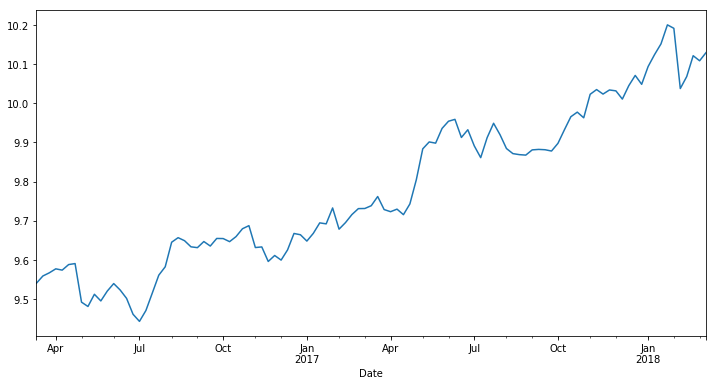

In [183]:
otg = otg.resample('W').mean()
otg.plot(figsize=(12,6))
plt.show()

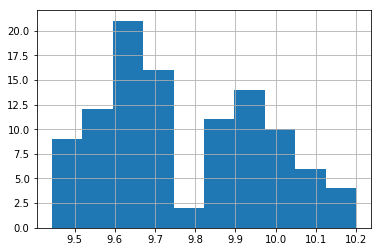

In [184]:
otg.hist()
plt.show()

In [185]:
itog = otg.describe()
itog

count    105.000000
mean       9.778610
std        0.198918
min        9.443361
25%        9.631773
50%        9.729740
75%        9.932342
max       10.199961
Name: Ln, dtype: float64

In [186]:
import numpy as np
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
#тест Харки — Бера
jb_test = sm.stats.stattools.jarque_bera(otg)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
itog


JB,p-value,skew,kurtosis
6.29904086096,0.0428726823695,0.287738513369,1.94709593983


In [187]:
#обобщенный тест Дикки-Фуллера
test = sm.tsa.adfuller(otg)
print("adf: ",test[0])
print("p-value: ",test[1])
print("Critical values: ",test[4])
if test[0]> test[4]['5%']: 
    print("есть единичные корни, ряд не стационарен")
else:
    print("единичных корней нет, ряд стационарен")

adf:  -0.314345134824
p-value:  0.923447916179
Critical values:  {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}
есть единичные корни, ряд не стационарен


In [188]:
otg1diff = otg.diff(periods=1).dropna()

In [189]:
test = sm.tsa.adfuller(otg1diff)
print("adf: ",test[0])
print("p-value: ",test[1])
print("Critical values: ",test[4])
if test[0]> test[4]['5%']: 
    print("есть единичные корни, ряд не стационарен")
else:
    print("единичных корней нет, ряд стационарен")

adf:  -8.06838917767
p-value:  1.57356343687e-12
Critical values:  {'1%': -3.4961490537199116, '5%': -2.8903209639580556, '10%': -2.5821223452518263}
единичных корней нет, ряд стационарен


In [190]:
#высокое p-value => нулевая гипотеза о равенстве средних верна => стационарностm ряда
m = otg1diff.index[round(len(otg1diff.index)/2+1)]
r1 = sm.stats.DescrStatsW(otg1diff[m:])
r2 = sm.stats.DescrStatsW(otg1diff[:m])
print("p-value: ", sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.559118812077


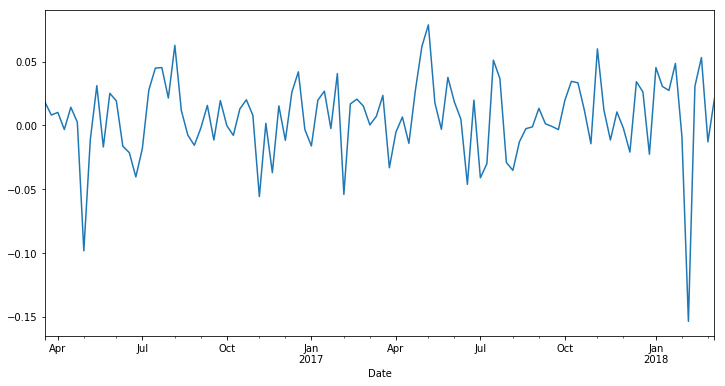

In [191]:
otg1diff.plot(figsize=(12,6))
plt.show()

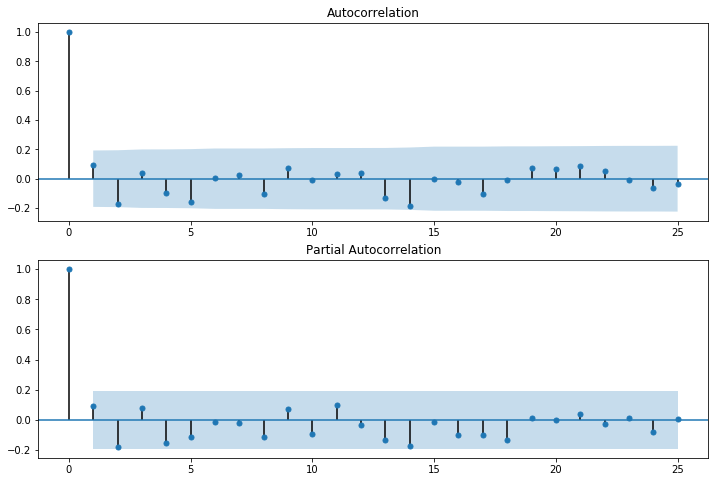

In [192]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(otg1diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(otg1diff, lags=25, ax=ax2)
plt.show()

In [218]:
src_data_model = otg[:'2017-10-12']
model = sm.tsa.ARIMA(src_data_model, order=(1,1,1)).fit(disp=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D.Ln   No. Observations:                   82
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 177.392
Method:                       css-mle   S.D. of innovations              0.028
Date:                Tue, 13 Mar 2018   AIC                           -346.784
Time:                        16:48:57   BIC                           -337.157
Sample:                    03-20-2016   HQIC                          -342.919
                         - 10-08-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.441      0.154      -0.002       0.011
ar.L1.D.Ln    -0.7977      0.108     -7.354      0.000      -1.010      -0.585
ma.L1.D.Ln     0.9409      0.064     14.691      0.000       0.815       1.066
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2536           +0.0000j            1.2536            0.5000
MA.1           -1.0628           +0.0000j            1.0628            0.5000
-----------------------------------------------------------------------------
"""

In [219]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]})

,Q-stat,p-value
0,0.406077,0.523967
1,0.434813,0.804603
2,0.838032,0.840350
3,0.947435,0.917659
4,3.981489,0.552084
5,4.866598,0.561033
6,5.591564,0.588164
7,5.640818,0.687394
8,5.724157,0.767177
9,5.756082,0.835323


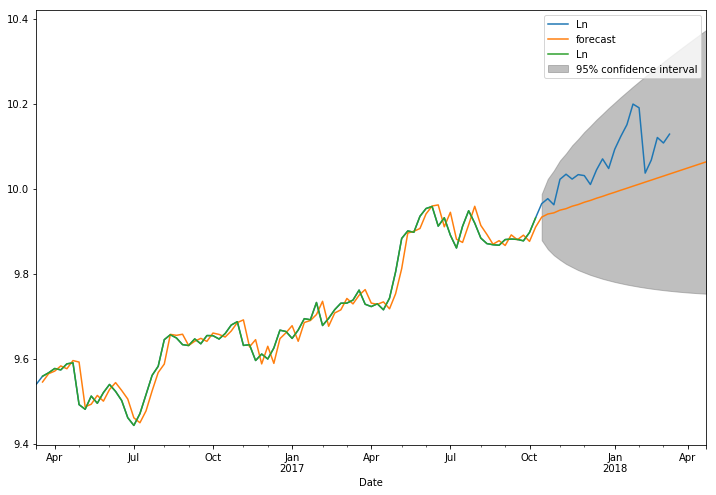

In [220]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = otg.ix['2016-03-11':].plot(ax=ax)
fig = model.plot_predict(1,110, ax=ax)
plt.show()